# Thư viện

In [20]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary

from model_resgcn import ResGCN
from data import ProcessDataset
from augmentation import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Dataset

In [3]:
data_transforms = {
    'train': TransformCompose([
        # InterpolateFrames(),
        # FlipSequence()
        # ShuffleSequence(enabled=True)
    ]),

    'test': TransformCompose([
        # InterpolateFrames(probability=1.0)
        # ShuffleSequence(enabled=True)
    ])
}

In [4]:
path_train = os.path.join("..", "data", "casia-b_pose_train_valid.csv")
path_test = os.path.join("..", "data", "casia-b_pose_test.csv")

In [5]:
dataset = {
    'train': ProcessDataset(csv_path=path_train, transform=data_transforms['train']),
    'test': ProcessDataset(csv_path=path_test, transform=data_transforms['test'])
}

# Model

## Load model và checkpoint

In [6]:
model = ResGCN()

In [7]:
checkpoint_dir = os.path.join(os.getcwd(), '..', 'save') 
best_checkpoint = os.path.join(checkpoint_dir, "best_checkpoint2.pth")

# Nếu checkpoint đã tồn tại thì load
if os.path.exists(best_checkpoint):
    checkpoint = torch.load(best_checkpoint, map_location=torch.device('cpu'))
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    print("Load checkpoint successfully")
else:
    print("No checkpoint found, starting training from scratch.")

Load checkpoint successfully


## Summary model

In [8]:
summary(model, input_size=(60, 17, 3))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
       BatchNorm2d-1            [-1, 3, 60, 17]               6
            Conv2d-2          [-1, 192, 60, 17]             768
  SpatialGraphConv-3           [-1, 64, 60, 17]               0
       BatchNorm2d-4           [-1, 64, 60, 17]             128
              ReLU-5           [-1, 64, 60, 17]               0
Spatial_Basic_Block-6           [-1, 64, 60, 17]               0
            Conv2d-7           [-1, 64, 60, 17]          36,928
       BatchNorm2d-8           [-1, 64, 60, 17]             128
              ReLU-9           [-1, 64, 60, 17]               0
Temporal_Basic_Block-10           [-1, 64, 60, 17]               0
    ResGCN_Module-11           [-1, 64, 60, 17]               0
           Conv2d-12            [-1, 8, 60, 17]             520
      BatchNorm2d-13            [-1, 8, 60, 17]              16
             ReLU-14            [-1

In [9]:
print(model)

ResGCN(
  (input_branches): ModuleList(
    (0): ResGCN_Input_Branch(
      (bn): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (layers): ModuleList(
        (0): ResGCN_Module(
          (scn): Spatial_Basic_Block(
            (conv): SpatialGraphConv(
              (gcn): Conv2d(3, 192, kernel_size=(1, 1), stride=(1, 1))
            )
            (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (relu): ReLU(inplace=True)
          )
          (tcn): Temporal_Basic_Block(
            (conv): Conv2d(64, 64, kernel_size=(9, 1), stride=(1, 1), padding=(4, 0))
            (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (relu): ReLU(inplace=True)
          )
        )
        (1): ResGCN_Module(
          (scn): Spatial_Bottleneck_Block(
            (conv_down): Conv2d(64, 8, kernel_size=(1, 1), stride=(1, 1))
            (bn_down): BatchNorm2d(8, eps=1e

In [10]:
def count_parameters(model):
    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Tổng số tham số     : {total:,}")
    print(f"Tham số cần học     : {trainable:,}")
    print(f"Tham số không học   : {total - trainable:,}")

count_parameters(model)

Tổng số tham số     : 319,530
Tham số cần học     : 319,530
Tham số không học   : 0


### Trọng số lớp cuối

In [11]:
last_conv_kernel = None

# Duyệt các layer trong main_stream để tìm Conv2d cuối
for layer in reversed(model.main_stream):
    for name, sub in reversed(list(layer.named_modules())):
        if isinstance(sub, nn.Conv2d):
            last_conv_kernel = sub
            print(f"Conv2d cuối cùng là: {name} trong lớp {layer.__class__.__name__}")
            print(f"Shape của kernel (trọng số): {sub.weight.shape}")
            break
    if last_conv_kernel:
        break

# Hiển thị toàn bộ kernel nếu tìm được
if last_conv_kernel:
    print(f"\nKernel (weight) của Conv2d cuối cùng:\n{last_conv_kernel.weight}")
else:
    print("Không tìm thấy lớp Conv2d nào trong main_stream.")

Conv2d cuối cùng là: tcn.conv_up trong lớp ResGCN_Module
Shape của kernel (trọng số): torch.Size([256, 32, 1, 1])

Kernel (weight) của Conv2d cuối cùng:
Parameter containing:
tensor([[[[ 5.6143e-40]],

         [[-4.3469e-40]],

         [[-6.2936e-40]],

         ...,

         [[-4.9024e-40]],

         [[-6.2995e-40]],

         [[ 6.2859e-40]]],


        [[[ 4.4493e-02]],

         [[ 3.1010e-02]],

         [[-2.3002e-01]],

         ...,

         [[-3.3855e-02]],

         [[ 3.4683e-01]],

         [[-7.1217e-02]]],


        [[[ 4.3441e-19]],

         [[ 4.8147e-12]],

         [[ 3.7250e-16]],

         ...,

         [[-5.1063e-26]],

         [[ 1.3372e-16]],

         [[ 1.1478e-20]]],


        ...,


        [[[-8.4660e-03]],

         [[ 2.7226e-01]],

         [[-2.3423e-01]],

         ...,

         [[ 3.6671e-01]],

         [[-2.1321e-01]],

         [[-1.1775e-01]]],


        [[[-3.1149e-03]],

         [[-1.8533e-01]],

         [[-2.0992e-01]],

         ...,

# Tạo embedding và hiển thị

## Tạo embedding

In [12]:
def generate_embeddings(dataset, subject_id_max=124):
    condition_map = {"nm": 0, "bg": 1, "cl": 2}
    embedding_list = []
    label_list = []
    for i in range(len(dataset)):
        data = dataset[i]
        subject_id = data['subject_id']
        # condition = data['condition']
        # condition_index = data['condition_index']
        # angle = data['angle']
        node_features = data['node_features']

        if subject_id > subject_id_max:
            continue

        # node_features = torch.tensor(node_features, dtype=torch.float32).to(device)

        emb_vector = model(node_features)  # output: (1, 128)
        emb_vector_np = emb_vector.squeeze(0).detach().cpu().numpy()

        embedding_list.append(emb_vector_np)
        label_list.append(subject_id)

    return embedding_list, label_list

## Hiển thị

In [13]:
def visualize_embedding_pca(embeddings_np, labels_np):

    # Giảm chiều xuống 2D với PCA
    pca = PCA(n_components=2)
    embeddings_2d = pca.fit_transform(embeddings_np)

    # Vẽ scatter plot với màu theo subject_id
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=labels_np, cmap='tab20', s=10, alpha=0.8)

    # Thêm colorbar với nhãn ID
    cbar = plt.colorbar(scatter, ticks=np.unique(labels_np))
    cbar.set_label('Subject ID')

    plt.title("PCA Visualization")
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [21]:
def visualize_embedding_tsne(embeddings_np, labels_np, perplexity=30, learning_rate=200, n_iter=1000):
    # Giảm chiều xuống 2D với t-SNE
    tsne = TSNE(n_components=2, perplexity=perplexity, learning_rate=learning_rate, n_iter=n_iter, random_state=42)
    embeddings_2d = tsne.fit_transform(embeddings_np)

    # Vẽ scatter plot với màu theo subject_id
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=labels_np, cmap='tab20', s=10, alpha=0.8)

    # Thêm colorbar với nhãn ID
    cbar = plt.colorbar(scatter, ticks=np.unique(labels_np))
    cbar.set_label('Subject ID')

    plt.title("t-SNE Visualization")
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

## Với tập train

In [14]:
embedding_list, label_list = generate_embeddings(dataset=dataset["train"])

In [15]:
# Chuyển danh sách thành numpy array
embeddings_np = np.stack(embedding_list)  # (N, 128)
labels_np = np.array(label_list) # (N,)

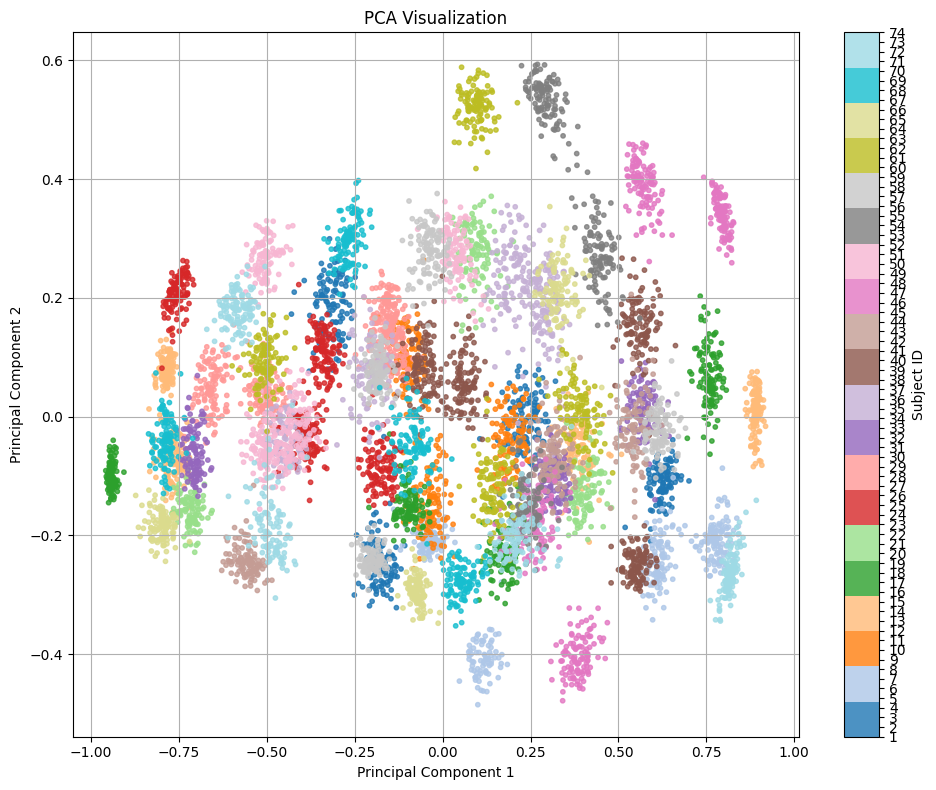

In [16]:
visualize_embedding_pca(embeddings_np, labels_np)

g:\AppStudy\Python\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


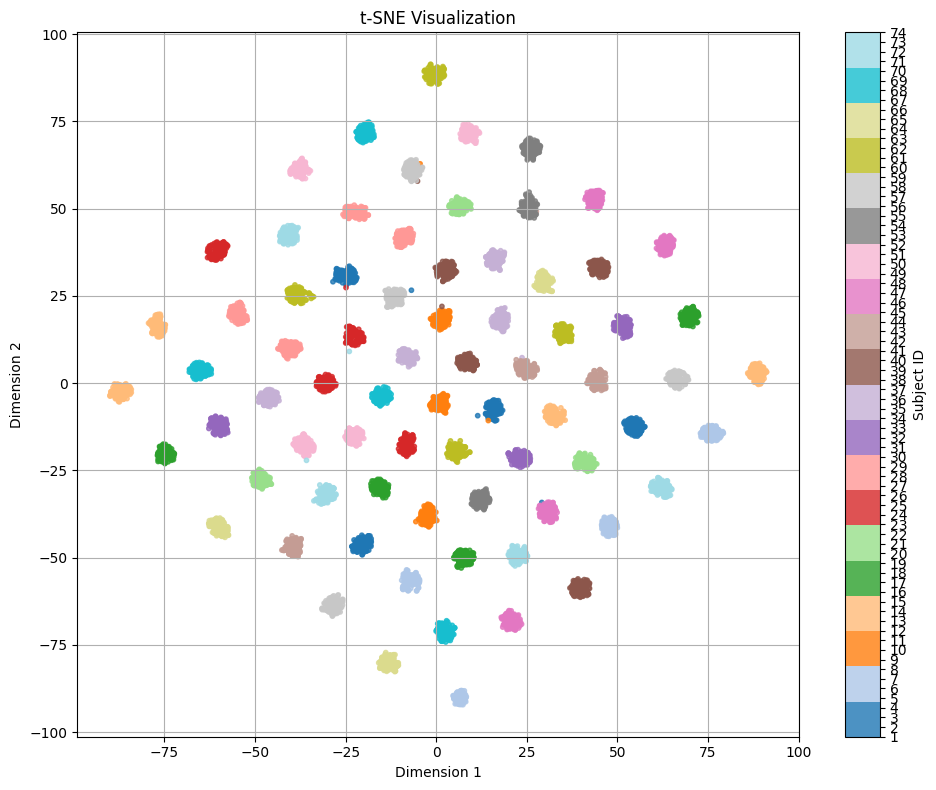

In [22]:
visualize_embedding_tsne(embeddings_np, labels_np)

## Với tập test

In [17]:
embedding_list_test, label_list_test = generate_embeddings(dataset=dataset["test"])

In [18]:
embeddings_np_test = np.stack(embedding_list_test)  # (N, 128)
labels_np_test = np.array(label_list_test) # (N,)

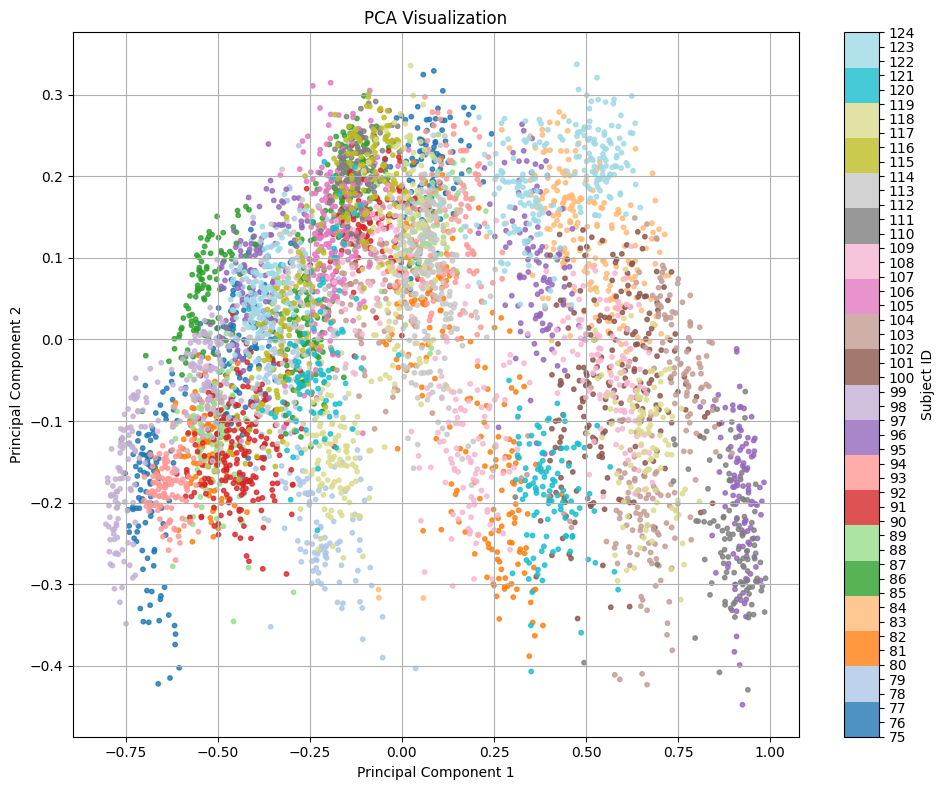

In [19]:
visualize_embedding_pca(embeddings_np_test, labels_np_test)

g:\AppStudy\Python\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


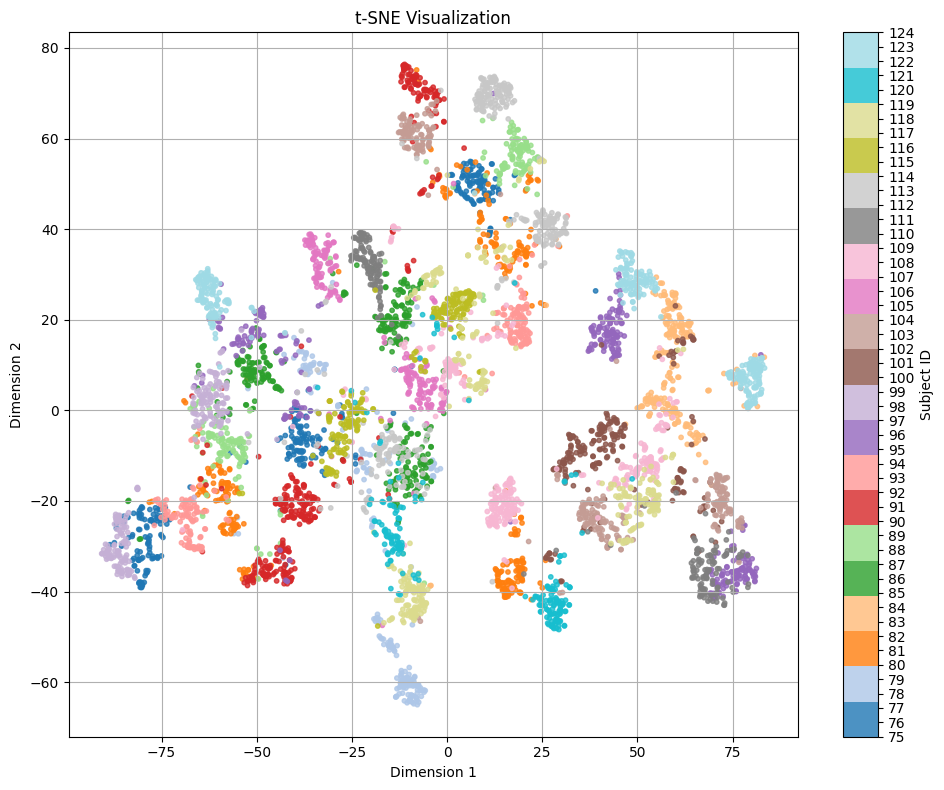

In [23]:
visualize_embedding_tsne(embeddings_np_test, labels_np_test)